In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, normalize
from scipy.stats import kurtosis, median_absolute_deviation, iqr
from keras.utils import to_categorical
from sklearn.metrics import plot_confusion_matrix
from runpbmet import dopbstuff 
from gatspy.periodic import LombScargleMultiband
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import KFold

#test

C:\Users\15173\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\15173\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\15173\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\15173\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

(7848, 168)
(7848, 168)
   object_id    fluxmean       std0        std1        std2        std3  \
0        615 -123.096998  83.944735  601.787302  455.121346  335.425053   
1        713   -1.423351   7.113509    5.712334    5.770738    6.450413   
2        730    2.267434   1.828872    1.807229    5.559483    8.191987   
3        745    8.909206   4.374445   25.964659   31.957997   34.967698   
4       1124    7.145702   2.360084    8.107525   21.319854   26.270649   

         std4        std5    median0     median1  ...  meanratio2  meanratio3  \
0  291.803449  294.779522 -10.015225 -488.057969  ...    1.093356    0.966500   
1    6.406989    7.094073  -3.096804   -0.561735  ...    0.535085    0.682655   
2   10.710344   13.332758   0.024093    0.171336  ...    0.985800    1.426632   
3   33.069053   26.060130   1.056714    0.888115  ...    1.060016    1.753098   
4   26.865913   21.434627   0.581027    1.154596  ...    1.543464    1.713935   

   meanratio4  meanratio5  stdratio0  

In [2]:
#gets the period of time series data, takes too long to actually use though.

def get_period(data):


    model = LombScargleMultiband(fit_period=True)

    t_min = 0.1
    t_max = 1

    model.optimizer.set(period_range=(t_min, t_max), first_pass_coverage=5)

    model.fit(data['mjd'], data['flux'], dy=data['flux_err'], filts=data['passband'])
    period = model.best_period

    print(period)

In [4]:
#calculates the wtable, which contains the proprortion of occurence of each label in a label set

def get_wtable(labels):
    
    unique, counts = np.unique(labels, return_counts=True)
    occur = dict(zip(unique, counts))

    num_classes = len(np.unique(labels))
    wtable = np.zeros(num_classes)

    #wtable - is a numpy 1d array with (the number of times class y_true occur in the data set)/(size of data set)
    for i in range(len(wtable)):

        wtable[i] = occur[unique[i]]/len(labels)
        
    return wtable

    

In [5]:
#estimate of relative amplitude of flux

def percent_amp(flux):
    
    min_flux = np.min(flux)
    max_flux = np.max(flux)
    med_flux = np.median(flux)
    
    
    return np.max([(min_flux/med_flux),(max_flux/med_flux)])
    
#ratio of difference between 95th and 5th percentiles and the median flux
def percent_diff_flux_p(flux):
    
    fifth = np.percentile(flux,5)
    ninetyfifth = np.percentile(flux,95)
    med_flux = np.median(flux)
    
    return((ninetyfifth-fifth)/med_flux)
 
#return variuous percentiles of flux    
def per_10(flux):
    
    return(np.percentile(flux,10))
    
def per_25(flux):
    
    return(np.percentile(flux,25))

def per_50(flux):
    
    return(np.percentile(flux,50))

def per_75(flux):
    
    return(np.percentile(flux,75))

def per_90(flux):
    
    return(np.percentile(flux,90))
  
def per_95(flux):
    
    return(np.percentile(flux,95))    
    
    
#finds largest/smallest jump/dip in flux    
def max_slope(flux):
    
    gradient = np.gradient(flux)
    
    return(np.max(gradient))

def min_slope(flux):
    
    gradient = np.gradient(flux)
    
    return(np.max(gradient))


#finds percent of observations where detected = 1
def percent_detected(detected):
    
    numdetected = np.sum(detected)
    
    return numdetected/len(detected)

In [6]:

    

#does major feature engineering
def do_aggs(measurements):
    
    preagg = measurements.copy()
    
    #inspired by https://www.kaggle.com/meaninglesslives/simple-neural-net-for-time-series-classification
    measurements['flux_ratio_sq'] = np.power(measurements['flux'] / measurements['flux_err'], 2.0)
    measurements['flux_by_flux_ratio_sq'] = measurements['flux'] * measurements['flux_ratio_sq']
    
    
    #rolling mean of previous 10 observations
    measurements['rollingmeanflux'] = measurements["flux"].rolling(10,min_periods = 1).mean()
    
    print("doing first batch of aggregations")
    
    
    #do mass feature engineering on various elements
    aggs = {
    
    'flux': ['max', 'min','median','mean',np.std,"skew",percent_amp,kurtosis,max_slope,min_slope,median_absolute_deviation,iqr,per_10,per_25,per_50,per_75,per_90,per_95],
    'flux_err' : ["mean","max","min",np.std,"skew",percent_amp,kurtosis,max_slope,min_slope,median_absolute_deviation,iqr,per_10,per_25,per_50,per_75,per_90,per_95],
    'passband': ['mean',"median","std"],
    'mjd': ['max','min',np.std],
    'detected': [percent_detected,"std"],
    'flux_ratio_sq': ['skew',"mean","median"],
    'flux_by_flux_ratio_sq':['skew',"mean","median"],
    'rollingmeanflux' : ['mean',"skew",kurtosis,max_slope,min_slope]

    }

    agg_df = measurements.groupby('object_id', as_index = False).agg(aggs)
    
    #fix column names
    agg_df.columns = list(map(''.join, agg_df.columns.values))
     
    
    #ratio of maximum flux to mean flux
    agg_df["max_mean"] = agg_df["fluxmax"] / agg_df["fluxmean"]
    
    
    print("doing second batch of aggregations, passbands")
    withpb = dopbstuff(preagg)
    
    print("done with hard engineering")
    
    agg_df = pd.merge(agg_df,withpb, on ="object_id")
    
    
    return agg_df

  
    
    
#processes data, returns various forms of labels     
def get_labels(full_df):
    
    #create train labels

    unique_labels = np.sort(full_df["target"].unique())
    all_labels = full_df["target"]
    empty_row = np.zeros(len(unique_labels))

    unique_labels_dict = {6:0, 15:1, 16:2, 42:3, 52:4, 53:5, 62:6, 64:7, 65:8, 67:9, 88:10, 90:11, 92:12, 95:13}
    my_train_labels = []

    for label in all_labels:

        newrow = empty_row.copy()

        newrow[unique_labels_dict[label]] = 1

        my_train_labels.append(newrow)
    
    return my_train_labels, unique_labels, all_labels



#processes data under assumption it is training data
def process_train(measurements,metadata):
    
   
    df = do_aggs(measurements)
    
    premerge = df
    
    df_2 = pd.merge(df,metadata, on ="object_id")
    

    values = {'distmod': 0}
    df_2 = df_2.fillna(value=values)
    
    labels, unique_labels, all_labs = get_labels(df_2)
    
    ids = df_2["object_id"]
    
    df_2 = df_2.drop(columns = ["object_id","target","mjdmax","mjdmin","mwebv"])#,"flux_by_flux_ratio_sqsum","flux_ratio_sqsum"])#,"hostgal_photoz","hostgal_photoz_err","mwebv"])

    df_2=tf.keras.utils.normalize(df_2, axis=1)
    #df_2 =  sk.preprocessing.normalize(df_2)
    
    return df_2, ids, labels, unique_labels, all_labs, premerge


#processes data under assumption it is test data

def process_test(measurements,metadata):

    #do aggregation
    print("doing agg")
    df = do_aggs(measurements)
     
    
    #merge with metadata
    print("doing merge")
    df_2 = pd.merge(df,metadata, on ="object_id")
    
    #values = {'distmod': 0, 'hostgal_specz' : 0}
    df_2 = df_2.fillna(0)
    
    ids = df_2["object_id"]
    df_2 = df_2.drop(columns = ["object_id","mjdmax","mjdmin","mwebv"])#,"flux_by_flux_ratio_sqsum"])#,"hostgal_photoz","hostgal_photoz_err","mwebv"])
    df_2 = df_2.replace([np.inf, -np.inf], 0)
    
    df_2=tf.keras.utils.normalize(df_2, axis=1)
    
    #df_2 =  sk.preprocessing.normalize(df_2)
    
    return df_2, ids



  

In [7]:
#handles making predictions, returns a dataframe contaning all preditions including class 99

def make_predictions(data,ids,model):
    
    

    prediction = model.predict(data)

    df_labels = ["class_6","class_15","class_16","class_42","class_52","class_53","class_62","class_64","class_65","class_67","class_88","class_90","class_92","class_95"]
    pred_df = pd.DataFrame(prediction,columns = df_labels)

    nrows = pred_df.shape[0]
    class_99_preds = np.zeros(nrows)
    
    

    for i in range(nrows):
        

        
        predsrow = prediction[i,:]
    
    

    
        sortedpreds = np.sort(predsrow)
    
        firstmax = sortedpreds[13]
        secondmax = sortedpreds[12]
    
    
        class_99_preds[i] = (1 - (firstmax + secondmax))/3
  
    
    pred_df.insert(loc=0, column='object_id', value=ids)
    pred_df.insert(loc=pred_df.shape[1], column='class_99', value=class_99_preds)
    
    
    return pred_df
    

In [8]:
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def mywloss(y_true,y_pred):  
    
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

In [10]:
def run_predictions(filename,batchnums,model):
    
    
    test_meta = pd.read_csv("./test_set_metadata.csv")
    
    first = True
    
    for bn in batchnums:
        
        print("starting bn = ", bn)
        testcsv = "test_set_batch" + str(bn) + ".csv"
        
        print("starting read")
        test_set = pd.read_csv(testcsv)
        
        print("starting process")
        full_test, test_ids =  process_test(test_set,test_meta)
        
        print("starting prediction")
        prediction = make_predictions(full_test,test_ids,model)
        
        if(first == True):
            prediction.to_csv(filename,index = False)
            
        else:
            
            prediction.to_csv(filename,index = False,mode = 'a',header = False)
        
        first = False
        
        print("done wiht bn = ", bn)
        print()
      

In [11]:
#plots lightcurve of specific object data


def make_lightcurve(data):
    


    mjd = data["mjd"]

    band_0 = data["flux"][data["passband"] == 0]
    mjd0 = data["mjd"][data["passband"] == 0]

    band_1 = data["flux"][data["passband"] == 1]
    mjd1 = data["mjd"][data["passband"] == 1]

    band_2 = data["flux"][data["passband"] == 2]
    mjd2 = data["mjd"][data["passband"] == 2]

    band_3 = data["flux"][data["passband"] == 3]
    mjd3 = data["mjd"][data["passband"] == 3]

    band_4 = data["flux"][data["passband"] == 4]
    mjd4 = data["mjd"][data["passband"] == 4]

    band_5 = data["flux"][data["passband"] == 5]
    mjd5 = data["mjd"][data["passband"] == 5]



    plt.figure(figsize = (8,8))
    plt.scatter(mjd0,band_0,color = "purple", label = "u - 0")
    plt.scatter(mjd1,band_1, color = "green", label = "g - 1")
    plt.scatter(mjd2,band_2, color = "red", label = "r - 2")
    plt.scatter(mjd3,band_3, color = "yellow", label = "i - 3")
    plt.scatter(mjd4,band_4, color = "brown", label = "z - 4 ")
    plt.scatter(mjd5,band_5, color = "black", label = "y - 5")
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

In [12]:
def plot_learning(learning, save = False, accfn = "learningacc.png", lossfn = "learningloss.png"):
    
    plt.figure(figsize = (12,8))
    
    plt.plot(learning.history["acc"][1:], color = "green", label = "training")
    plt.plot(learning.history['val_acc'][1:], color = "blue", label = "validation")
    
    
    
    plt.xlabel("epoch",fontsize = 18)
    plt.xticks(fontsize = 16)
    
    
    plt.ylabel("accuracy", fontsize = 18)
    plt.yticks(fontsize = 16)
    
    plt.title("model learning - accuracy", fontsize = 22)
    
    plt.legend(fontsize = 16)
    
    if(save == False):
        plt.show()
        
    if(save == True):
        plt.savefig(accfn, dpi = 600)
        
        
    plt.figure(figsize = (12,8))
    
    plt.plot(learning.history["loss"][1:], color = "green", label = "training")
    plt.plot(learning.history['val_loss'][1:], color = "blue", label = "validation")
    
    
    
    plt.xlabel("epoch",fontsize = 18)
    plt.xticks(fontsize = 16)
    
    
    plt.ylabel("loss", fontsize = 18)
    plt.yticks(fontsize = 16)
    
    plt.title("model learning - loss", fontsize = 22)
    
    plt.legend(fontsize = 16)
    
    if(save == False):
        plt.show()
        
    if(save == True):
        plt.savefig(lossfn, dpi = 600)
        




In [14]:
def new_model(full_train):
    
    num_neurons = 128*4
    num_features = np.shape(full_train)[1]
    num_classes = 14
    drop_rate = 0.40
    
    
    model = tf.keras.models.Sequential([

    
      tf.keras.layers.Dense(num_neurons, input_dim = num_features, activation='sigmoid'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(drop_rate),

      tf.keras.layers.Dense(num_neurons, input_dim = num_features, activation='sigmoid'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(drop_rate), 

      tf.keras.layers.Dense(num_neurons//2, input_dim = num_features, activation='sigmoid'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(drop_rate), 

      tf.keras.layers.Dense(num_neurons//4, input_dim = num_features, activation='sigmoid'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(drop_rate), 

      tf.keras.layers.Dense(num_classes, activation='softmax')

    ])
    
    return model




In [15]:
#load data
train_set = pd.read_csv("training_set.csv")
train_meta = pd.read_csv("training_set_metadata.csv")


In [16]:
full_train, train_ids, train_labels, unique_train_labels, all_labs, premerge = process_train(train_set,train_meta)

doing first batch of aggregations


C:\Users\15173\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\15173\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\15173\anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in longlong_scalars


doing second batch of aggregations, passbands
(7848, 168)
done with hard engineering


In [17]:
np.shape(full_train)

(7848, 229)

In [18]:


X = np.asarray(full_train)
y = np.asarray(train_labels)


models = np.array(())
fits = np.array(())


k_fold = KFold(n_splits=5)
for train_indices, test_indices in k_fold.split(X):
    #print('Train: %s | test: %s' % (train_indices, test_indices))
    
    
    train_x = X[train_indices]
    eval_x = X[test_indices]
    
    
    train_y = y[train_indices]
    eval_y = y[test_indices]
    
    
    wtablelabs = np.asarray(all_labs)
    wtable = get_wtable(wtablelabs)
    
    newmodel = new_model(train_x)
    
    
    newmodel.compile(optimizer='adam', loss= mywloss, metrics=['accuracy'])
    fit = newmodel.fit(train_x, train_y, validation_data = [eval_x,eval_y], epochs = 150, batch_size = 20, shuffle = True)
    
    models = np.append(models,newmodel)
    fits = np.append(fits,fit)
    
    
    print(len(train_indices))
    print(len(test_indices))
    
    
    


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 6278 samples, validate on 1570 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/150
6278/6278 [==============================] - 4s 673us/sample - loss: 3.0282 - acc: 0.1446 - val_loss: 2.0538 - val_acc: 0.1108
Epoch 2/150
6278/6278 [==============================] - 2s 396us/sample - loss: 2.5942 - acc: 0.1838 - val_loss: 1.8654 - val_acc: 0.2000
Epoch 3/150
6278/6278 [==============================] - 2s 375us/sample - loss: 2.4218 - acc: 0.2115 - val_loss: 1.8646 - val_acc: 0.2038
Epoch 4/150
6278/6278 [==============================] - 2s 384us/sample - loss: 2.3137 - acc: 0.2421 - val_loss: 1.7341 - val_acc: 0.2433
Epoch 5/150
6278/6278 [==============================] - 2s 384us/sample - loss: 2.1837 - acc: 0.2636 - val_loss: 1.8136 - val_acc: 0.2490
Epoch 6/150
6278/6278 [======================

6278/6278 [==============================] - 3s 491us/sample - loss: 1.4866 - acc: 0.4237 - val_loss: 1.2478 - val_acc: 0.4325
Epoch 113/150
6278/6278 [==============================] - 4s 596us/sample - loss: 1.4819 - acc: 0.4269 - val_loss: 1.3361 - val_acc: 0.4720
Epoch 114/150
6278/6278 [==============================] - 3s 460us/sample - loss: 1.4165 - acc: 0.4325 - val_loss: 1.1926 - val_acc: 0.3490
Epoch 115/150
6278/6278 [==============================] - 3s 448us/sample - loss: 1.4543 - acc: 0.4143 - val_loss: 1.3084 - val_acc: 0.4401
Epoch 116/150
6278/6278 [==============================] - 3s 437us/sample - loss: 1.4450 - acc: 0.4301 - val_loss: 1.2854 - val_acc: 0.3529
Epoch 117/150
6278/6278 [==============================] - 3s 441us/sample - loss: 1.4632 - acc: 0.4188 - val_loss: 1.2671 - val_acc: 0.4344
Epoch 118/150
6278/6278 [==============================] - 3s 493us/sample - loss: 1.4269 - acc: 0.4290 - val_loss: 1.3502 - val_acc: 0.3497
Epoch 119/150
6278/6278 [==

Epoch 20/150
6278/6278 [==============================] - 3s 410us/sample - loss: 1.7040 - acc: 0.3558 - val_loss: 1.6107 - val_acc: 0.3217
Epoch 21/150
6278/6278 [==============================] - 3s 412us/sample - loss: 1.6713 - acc: 0.3495 - val_loss: 1.5261 - val_acc: 0.3624
Epoch 22/150
6278/6278 [==============================] - 3s 463us/sample - loss: 1.6733 - acc: 0.3528 - val_loss: 1.5628 - val_acc: 0.3669
Epoch 23/150
6278/6278 [==============================] - 2s 395us/sample - loss: 1.6370 - acc: 0.3563 - val_loss: 1.5602 - val_acc: 0.4000
Epoch 24/150
6278/6278 [==============================] - 3s 419us/sample - loss: 1.6831 - acc: 0.3460 - val_loss: 1.5710 - val_acc: 0.3949
Epoch 25/150
6278/6278 [==============================] - 3s 419us/sample - loss: 1.6093 - acc: 0.3729 - val_loss: 1.5675 - val_acc: 0.3586
Epoch 26/150
6278/6278 [==============================] - 3s 403us/sample - loss: 1.6466 - acc: 0.3617 - val_loss: 1.4691 - val_acc: 0.3994
Epoch 27/150
6278/62

6278/6278 [==============================] - 3s 399us/sample - loss: 1.3764 - acc: 0.4186 - val_loss: 1.3594 - val_acc: 0.3758
Epoch 137/150
6278/6278 [==============================] - 3s 409us/sample - loss: 1.3737 - acc: 0.4078 - val_loss: 1.4401 - val_acc: 0.4369
Epoch 138/150
6278/6278 [==============================] - 3s 406us/sample - loss: 1.3767 - acc: 0.4223 - val_loss: 1.4245 - val_acc: 0.4382
Epoch 139/150
6278/6278 [==============================] - 3s 422us/sample - loss: 1.3677 - acc: 0.4232 - val_loss: 1.4405 - val_acc: 0.4344
Epoch 140/150
6278/6278 [==============================] - 3s 405us/sample - loss: 1.4138 - acc: 0.4169 - val_loss: 1.4316 - val_acc: 0.4331
Epoch 141/150
6278/6278 [==============================] - 3s 410us/sample - loss: 1.3939 - acc: 0.4113 - val_loss: 1.4233 - val_acc: 0.4006
Epoch 142/150
6278/6278 [==============================] - 3s 401us/sample - loss: 1.4200 - acc: 0.4071 - val_loss: 1.4138 - val_acc: 0.4427
Epoch 143/150
6278/6278 [==

Epoch 44/150
6278/6278 [==============================] - 2s 380us/sample - loss: 1.5033 - acc: 0.3915 - val_loss: 1.6793 - val_acc: 0.3299
Epoch 45/150
6278/6278 [==============================] - 2s 386us/sample - loss: 1.5225 - acc: 0.3831 - val_loss: 1.4572 - val_acc: 0.4000
Epoch 46/150
6278/6278 [==============================] - 2s 379us/sample - loss: 1.5459 - acc: 0.3802 - val_loss: 1.4942 - val_acc: 0.4287
Epoch 47/150
6278/6278 [==============================] - 2s 384us/sample - loss: 1.5241 - acc: 0.3904 - val_loss: 1.4559 - val_acc: 0.4045
Epoch 48/150
6278/6278 [==============================] - 2s 381us/sample - loss: 1.4834 - acc: 0.3944 - val_loss: 1.5329 - val_acc: 0.4236
Epoch 49/150
6278/6278 [==============================] - 2s 382us/sample - loss: 1.5146 - acc: 0.3753 - val_loss: 1.4791 - val_acc: 0.4127
Epoch 50/150
6278/6278 [==============================] - 2s 390us/sample - loss: 1.5171 - acc: 0.3920 - val_loss: 1.5083 - val_acc: 0.4006
Epoch 51/150
6278/62

6279/6279 [==============================] - 2s 385us/sample - loss: 1.9059 - acc: 0.3004 - val_loss: 1.7745 - val_acc: 0.3518
Epoch 10/150
6279/6279 [==============================] - 2s 389us/sample - loss: 1.8312 - acc: 0.3227 - val_loss: 1.8783 - val_acc: 0.3308
Epoch 11/150
6279/6279 [==============================] - 3s 399us/sample - loss: 1.7997 - acc: 0.3274 - val_loss: 1.7407 - val_acc: 0.4213
Epoch 12/150
6279/6279 [==============================] - 2s 389us/sample - loss: 1.8062 - acc: 0.3348 - val_loss: 1.6598 - val_acc: 0.3512
Epoch 13/150
6279/6279 [==============================] - 2s 392us/sample - loss: 1.7571 - acc: 0.3340 - val_loss: 1.7191 - val_acc: 0.3614
Epoch 14/150
6279/6279 [==============================] - 2s 389us/sample - loss: 1.7734 - acc: 0.3294 - val_loss: 2.0839 - val_acc: 0.3276
Epoch 15/150
6279/6279 [==============================] - 2s 394us/sample - loss: 1.7553 - acc: 0.3386 - val_loss: 1.8191 - val_acc: 0.3722
Epoch 16/150
6279/6279 [=========

6279/6279 [==============================] - 2s 386us/sample - loss: 1.3932 - acc: 0.4007 - val_loss: 1.4231 - val_acc: 0.4825
Epoch 126/150
6279/6279 [==============================] - 2s 389us/sample - loss: 1.3799 - acc: 0.4219 - val_loss: 1.4714 - val_acc: 0.4270
Epoch 127/150
6279/6279 [==============================] - 2s 392us/sample - loss: 1.3866 - acc: 0.4173 - val_loss: 1.4544 - val_acc: 0.4691
Epoch 128/150
6279/6279 [==============================] - 2s 396us/sample - loss: 1.3518 - acc: 0.4157 - val_loss: 1.4400 - val_acc: 0.4379
Epoch 129/150
6279/6279 [==============================] - 2s 397us/sample - loss: 1.3982 - acc: 0.4085 - val_loss: 1.5288 - val_acc: 0.4410
Epoch 130/150
6279/6279 [==============================] - 2s 388us/sample - loss: 1.3531 - acc: 0.4193 - val_loss: 1.4598 - val_acc: 0.4525
Epoch 131/150
6279/6279 [==============================] - 2s 389us/sample - loss: 1.3805 - acc: 0.4155 - val_loss: 1.4060 - val_acc: 0.3913
Epoch 132/150
6279/6279 [==

6279/6279 [==============================] - 2s 397us/sample - loss: 1.5327 - acc: 0.3677 - val_loss: 1.7562 - val_acc: 0.4136
Epoch 34/150
6279/6279 [==============================] - 3s 407us/sample - loss: 1.5109 - acc: 0.3696 - val_loss: 1.7338 - val_acc: 0.4245
Epoch 35/150
6279/6279 [==============================] - 3s 413us/sample - loss: 1.5076 - acc: 0.3884 - val_loss: 1.7520 - val_acc: 0.3977
Epoch 36/150
6279/6279 [==============================] - 3s 407us/sample - loss: 1.4857 - acc: 0.3786 - val_loss: 1.7416 - val_acc: 0.4481
Epoch 37/150
6279/6279 [==============================] - 3s 402us/sample - loss: 1.5324 - acc: 0.3749 - val_loss: 1.7535 - val_acc: 0.4060
Epoch 38/150
6279/6279 [==============================] - 2s 390us/sample - loss: 1.5167 - acc: 0.3870 - val_loss: 1.7752 - val_acc: 0.4398
Epoch 39/150
6279/6279 [==============================] - 2s 392us/sample - loss: 1.5042 - acc: 0.3800 - val_loss: 1.8125 - val_acc: 0.4283
Epoch 40/150
6279/6279 [=========

6279/6279 [==============================] - 2s 386us/sample - loss: 1.2930 - acc: 0.4278 - val_loss: 1.6066 - val_acc: 0.4289
Epoch 150/150
6279/6279 [==============================] - 2s 388us/sample - loss: 1.3058 - acc: 0.4295 - val_loss: 1.5708 - val_acc: 0.4455
6279
1569


In [19]:
evaluations = np.array(())

for fit in fits:
    
    length = len(fit.history['val_loss'][1:])
  


    lastfiveval = fit.history['val_loss'][(length - 4):length + 1]
    lastfivetrain = fit.history['loss'][(length - 4):length + 1]

    
    evaluation = np.mean(lastfiveval) + np.mean(lastfivetrain)
    evaluations = np.append(evaluations,evaluation)
    
       
    

In [32]:
#select best model, isn't great though, so I also look by hand and see which is best

min_eval = np.min(evaluations)


for i in range(len(evaluations)):
    
    if(evaluations[i] == min_eval):
        
        ind = i
        break
    

best_model = models[3]
best_fit = fits[3]

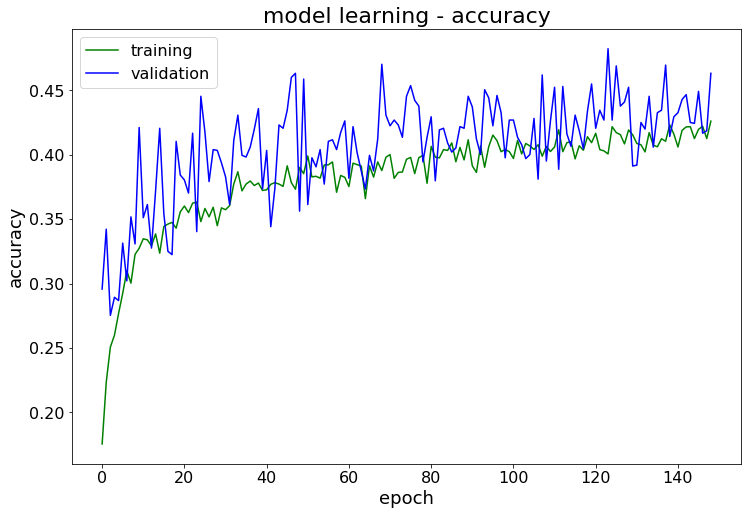

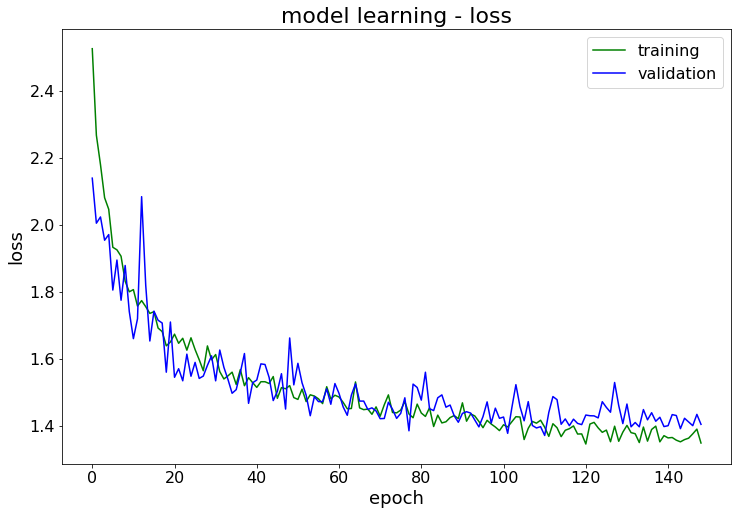

In [33]:
plot_learning(best_fit, save = True)

In [21]:
batchnums = ["2"]

In [24]:
run_predictions("test_predx.csv",batchnums,best_model)

NameError: name 'best_model' is not defined